In [4]:
%pip install keras
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.
  Using cached tensorflow-2.17.0-cp311-cp311-macosx_12_0_arm64.whl.metadata (4.1 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached h5py-3.11.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (2.5 kB)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.2/236.2 MB 5.5 MB/s eta 0:00:00:00:0100:01
Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
Using cached flatbuffers-24.3.25-py2.py3

In [1]:
import os

# os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import keras
from keras import layers
from keras import ops

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
imgs = np.load("/Users/anavbo/Desktop/Personal/ASDRP/augment_images.npy")

In [4]:
df = pd.read_csv("/Users/anavbo/Desktop/Personal/ASDRP/HAM10000_metadata_augmented.csv")
df.head()

,image_id,dx,dx_type,lesion_id,sex,age,localization
0,ISIC_0034320,nv,follow_up,HAM_0000550,male,45.0,trunk
1,ISIC_0034320,nv,follow_up,HAM_0003577,male,50.0,lower extremity
2,ISIC_0034320,nv,follow_up,HAM_0001477,female,55.0,trunk
3,ISIC_0034320,nv,follow_up,HAM_0000484,male,40.0,trunk
4,ISIC_0034320,mel,histo,HAM_0003350,male,60.0,chest


In [5]:
print(df.shape)
print(imgs.shape)

(40949, 7)
(40949, 100, 100, 3)


In [6]:
classes=  7
shape = (100, 100, 3)
split = 35000
(x_train, y_train), (x_test, y_test) = (imgs[:split], df["dx"][:split]), (imgs[split:], df["dx"][split:])
y_train = pd.get_dummies(y_train, dtype=np.float32).to_numpy()
y_test = pd.get_dummies(y_test, dtype=np.float32).to_numpy()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(35000, 100, 100, 3) (35000, 7) (5949, 100, 100, 3) (5949, 7)


In [19]:
class CFG:
    learning_rate = 0.001
    weight_decay = 0.0001
    batch_size = 256
    num_epochs = 10  # For real training, use num_epochs=100. 10 is a test value
    image_size = 100  # We'll resize input images to this size
    patch_size = 10  # Size of the patches to be extract from the input images
    num_patches = (image_size // patch_size) ** 2
    projection_dim = 64
    num_heads = 4
    transformer_units = [
        projection_dim * 2,
        projection_dim
    ],  # Size of the transformer layers
    transformer_layers = 8
    mlp_head_units = [
        2048,
        1024
    ]  # Size of the dense layers of the final classifier

In [13]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [14]:
ops.shape(x_train)

(35000, 100, 100, 3)

In [25]:
x_train.shape

(35000, 100, 100, 3)

In [26]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(
            images=images,
            size = self.patch_size
        )
        patches = ops.reshape(
            patches,
            (batch_size, num_patches_h * num_patches_w, self.patch_size ** 2 * channels)
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

Image size: 100 X 100
Patch size: 10 X 10
Patches per image: 100
Elements per patch: 300


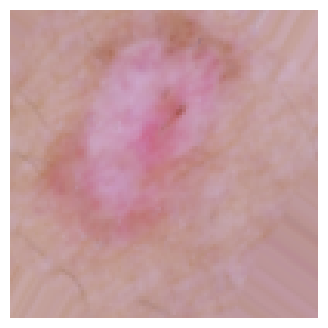

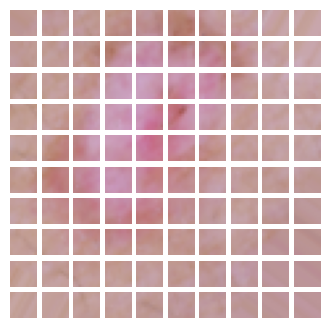

In [27]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(CFG.image_size, CFG.image_size)
)
patches = Patches(CFG.patch_size)(resized_image)
print(f"Image size: {CFG.image_size} X {CFG.image_size}")
print(f"Patch size: {CFG.patch_size} X {CFG.patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (CFG.patch_size, CFG.patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")